# MODNet 'matbench_dielectric' benchmarking

In [ ]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

## Data exploration

In [2]:
df = load_dataset("matbench_dielectric")
# df["composition"] = df["composition"].map(Composition)

Fetching matbench_dielectric.json.gz from https://ml.materialsproject.org/projects/matbench_dielectric.json.gz to /home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/datasets/matbench_dielectric.json.gz


In [3]:
df.columns

Index(['structure', 'n'], dtype='object')

### Target space

In [5]:
df.describe()

,n
count,4764.000000
mean,2.428314
std,2.101722
min,1.000000
25%,1.684573
50%,2.060778
75%,2.595320
max,62.062998


Text(0.5, 0, 'n')

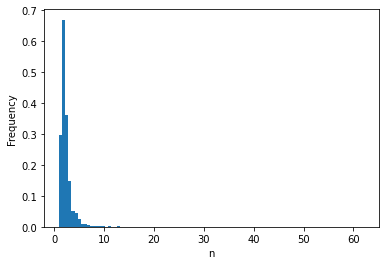

In [6]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["n"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("n")

## Featurization and feature selection

In [23]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
PRECOMPUTED_MODDATA = "./precomputed/dielectric_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_dielectric")
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["n"].tolist(), 
        target_names=["n"],
        featurizer=DeBreuck2020Featurizer(n_jobs=8)
    )
    data.featurize()
    data.save(PRECOMPUTED_MODDATA)
    # data.feature_selection(n=-1)

INFO:root:Loaded DeBreuck2020Featurizer featurizer.
INFO:root:Computing features, this can take time...
INFO:root:Applying composition featurizers...
INFO:root:Applying featurizers (AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7f3c8a7cfd60>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'maximum', 'range', 'mean', 'avg_dev',
                       'mode']), IonProperty(), Miedema(ss_types=['min'], struct_types=['in

INFO:root:Applying oxidation state featurizers...


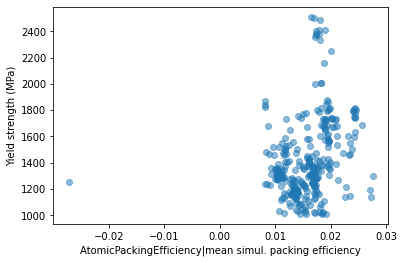

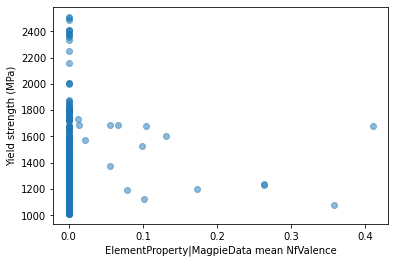

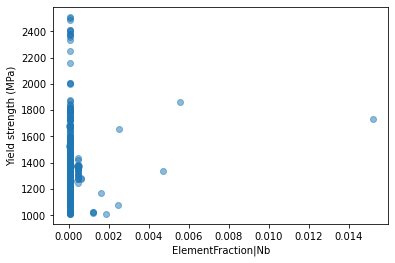

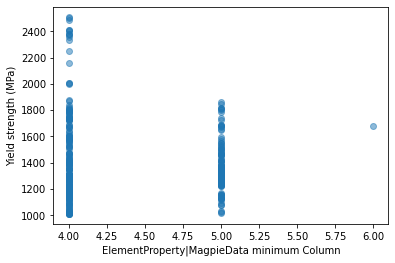

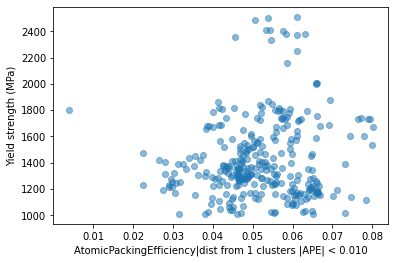

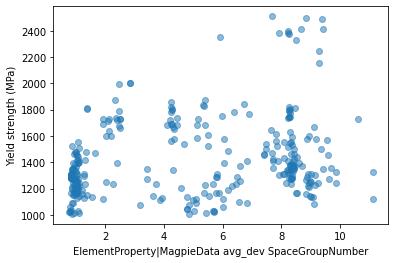

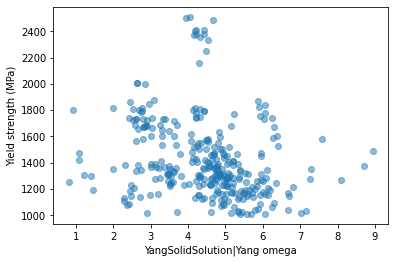

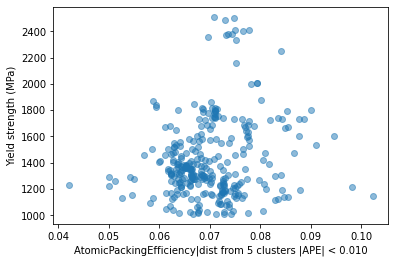

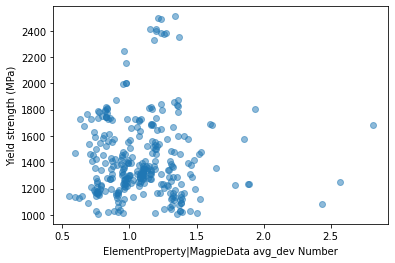

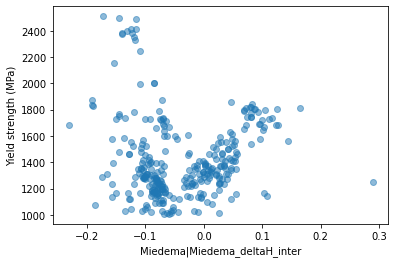

In [4]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("Yield strength (MPa)")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [ ]:
print("test")